# CH3. Statistial Experiments and Significance Testin

**통계적 실험과 유의성검정**

3.1 A/B 검정

3.2 가설 검정

**3.3 재표본추출(순열검정, 전체순열검정, 부트스트랩 순열검정)**


# A/B 검정
---

3.1 A/B Test

**연구 대상을 두 가지 이상의 그룹 중 하나에 할당한다. 그리고 서로 다른 처리 조건을 제외한 나머지 조건들은 동일하게 처리한다.**

**이상적으로는 대상들은 그룹에 무작위 배정되도록 한다.**

용어정리

> 처리(treatment): 어떤 대상에 주어지는 특별한 환경이나 조건

> 처리군: 특정 처리에 노출된 대상들의 집단

> 대조군: 어떤 처리도 하지 않은 대상들의 집단

> 임의화(randomization): 처리를 적용할 대상을 임의로 결정하는 과정

> subject: 처리를 적용할 개체 대상

> 검정통계량(test statistic): 처리 효과를 측정하기 위한 지표

예로 이런 문제에 사용된다. 

    종자 발아 조건을 보기위해 두 가지 토양 처리를 검정
    암을 더 효과적으로 억제하는 두 가지 치료법을 검정
    두 가지 가격을 검정하여 더 많은 순이익을 산출하는 쪽을 결정

추가로

> 맹검연구(blind study): 피실험자가 처리 A나 처리 B 중 어느 것을 받고 있는지 알지 못하도록 하는 연구 방식. 특정 처리를 받는 것에 대한 인식이 반응에 영향을 줄 수 있기 때문. 이중 맹검 연구는 조사자와 진행자 모두가 어떤 대상이 어떤 처리를 받았는지 모르게 하는 연구 방식.



# 가설검정(유의성검정)
---
3.2 Hypothesis test (significance test)

전통적인 통계 분석 방법으로, 목적은 관찰된 효과가 우연에 의한 것인지 여부를 알아내는 것이다.

인간은 우연히 발생한 일도 흔하지 않다면, 뭔가 의미가 있을것이라고 해석하는 경향을 가지고 있다. 그러므로 실험에서 얻은 그룹 간의 차이가 무작위로 얻을 수 있는 합리적인 수준과는 극단적으로 다르다는 증거가 필요하다는 논리를 바탕으로 한다.

**그룹들이 보이는 결과는 서로 동일하며, 그룹 간의 차이는 우연에 의한 결과라는 것을 기본 가정으로 하며 이 가정을 귀무가설이라고 부른다.**

용어정리

> 귀무가설(null hypothesis): 우연 때문이라는 가설(유의어: 영가설)

> 대립가설(alternative hypothesis): 귀무가설과의 대조(증명하고자 하는 가설)

> 일원검정(one-way test): 한 방향으로만 우연히 일어날 확률을 계산하는 가설 검정

> 이원검정(two-way test): 양방향으로 우연히 일어날 확률을 계산하는 가설 검정



# 재표본추출
---
3.3 Resampling

용어정리

> 순열검정(permutation test): 두 개 이상의 표본을 함께 결합하여 관측값들을 무작위로 (또는 전부를) 재표본으로 추출하는 과정을 말한다(유의어: 임의화검정, 임의순열검정, 정확검정)

> 재표본추출: 관측 데이터로부터 반복해서 표본추출하는 과정

> 복원/비복원(with or without replacement): 표본을 추출할 때, 이미 한 번 뽑은 데이터를 다음번 추출을 위해 다시 제자리에 돌려 놓거나/다음 추출에서 제외하는 표본추출 방법



In [1]:
# 라이브러리 불러오기

%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from scipy import stats
from sklearn.utils import resample
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import seaborn as sns
import matplotlib.pylab as plt

## 데이터 import

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

# Resampling

## 순열검정

순열 과정에는 두 개 이상의 표본이 관여되며 이들은 통상적으로 A/B 또는 기타 가설검정을 위해 사용되는 그룹들이다. 


1. 여러 그룹의 결과를 단일 데이터 집합으로 결합한다.
2. 결합된 데이터를 잘 섞은 후, 그룹 A와 동일한 크기의 표본을 무작위로 (비복원) 추출한다.
3. 나머지 데이터에서 그룹 B와 동일한 크기의 샘플을 무작위로(비복원) 추출한다.
4. C, D 등의 그룹에 대해서도 동일한 작업을 수행한다. 이제 원본 표본의 크기를 반영하는 재표본을 수집했다.
5. 원래 샘플(예를 들면 그룹 비율의 차이)에 대해 구한 통계량 또는 추정치가 무엇이었든 간에 지금 추출한 재표본에 대해 모두 다시 계산하고 기록한다. 이것으로 한 번의 순열 반복이 진행된다.
6. 앞선 단계들을 R번 반복하여 검정통계량의 순열분포를 얻는다.

그룹 간의 차이점으로 돌아가서 순열 과정에서 얻은 집합에서의 차이와 비교한다.

이 관찰된 차이가 순열로 보이는 차이의 집합 안에 잘 들어 있다면, 우리는 어떤 것도 증명할 수 없다 = 관찰된 차이가 우연히 일어날 수 있는 범위 안에 있다는 말.

반대로 관찰된 차이가 대부분의 순열 분포 바깥에 있다면, 이것을 우연 때문이 아니라고 결론 내릴 수 있다. = 통계적으로 유의미하다라고 할 수 있다.

## 예제: 웹 점착성

두 가지 디자인을 놓고 각 페이지의 세션 시간을 비교한다.

In [4]:
# 웹페이지 데이터 csv로 불러오기 
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)

# session_times의 시간컬럼을 본다. 단위의 문제가 있으니(소수점 편의상) 똑같이 100을 곱한다.
session_times.Time = 100 * session_times.Time

In [8]:
session_times.head(5)

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


### 웹 페이지 체류 시간 박스플롯

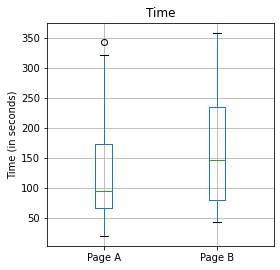

In [9]:
# 박스플롯으로 그려본다.

ax = session_times.boxplot(by = 'Page', column = 'Time',
                          figsize = (4,4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

박스플롯에 의하면 페이지 B가 방문자들의 체류시간이 더 긴 것으로 나타났다.

각 그룹의 평균 시간을 구한다면 이렇게 구할 수 있다.

### 페이지 간 체류시간 차이

In [11]:
mean_pA = session_times[session_times.Page == 'Page A'].Time.mean()
mean_pB = session_times[session_times.Page == 'Page B'].Time.mean()

In [12]:
mean_pB - mean_pA

35.66666666666667

페이지 B의 세션시간이 A보다 평균 35.67초 정도 더 길다.

이때 이 차이가 우연인지 통계적으로 중요한지 판단해야하는 문제가 있다는 것이다!

이때 순열검정을 이용한다.

잘 섞어서 A 페이지 그룹 데이터 개수와 B 페이지 그룹 데이터 개수 만큼 표본을 추출한다.

In [13]:
session_times['Page'].value_counts()

Page A    21
Page B    15
Name: Page, dtype: int64

### 순열검정 진행

순열검정을 적용하기 위해 랜덤하게 할당할 수 있는 함수를 만든다.

In [14]:
# 랜덤하게 개수에 맞춰 데이터를 그룹을 나눈 다음 B군의 평균과 A군의 평균의 차를 반환한다.

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [ ]:
# 함수를 이용하여, R =1000 번 진행 후 이의 관찰된 차이를 구한다

